# Init class


In [5]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice
import matplotlib.pyplot as plt
import os

class AntColony(object):

    def __init__(self, distances, coordinates, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            coordinates (list): List of coordinates for each vertex
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances  = distances
        self.coordinates = coordinates
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        # Bật chế độ interactive để hiển thị nhiều đồ thị
        plt.ion()

        # Đảm bảo thư mục lưu hình tồn tại
        os.makedirs('graphs', exist_ok=True)

        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)

        print("Tọa độ các đỉnh:")
        for i, coord in enumerate(self.coordinates):
            print(f"  Đỉnh {i}: {coord}")
        print()

        # Vẽ đồ thị ban đầu
        self.plot_graph(title="Đồ thị ban đầu - Các đỉnh", iteration=0, show_paths=False,
                        save_path=f"./graphs/iteration_0_graph.png")

        for i in range(self.n_iterations):
            print(f"=== Iteration {i+1} ===")
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])

            # Vẽ đường đi của các con kiến trong iteration này và lưu hình
            self.plot_graph(all_paths, shortest_path, f"Iteration {i+1}", i+1,
                            save_path=f'./graphs/iteration_{i+1}_graph.png')

            print(f"Đường đi của các con kiến trong iteration {i+1}:")
            for ant_idx, (path, dist) in enumerate(all_paths):
                print(f"  Kiến {ant_idx+1}:")
                path_coords = []
                for step in path:
                    from_node, to_node = step
                    from_coord = self.coordinates[from_node]
                    to_coord = self.coordinates[to_node]
                    path_coords.append(f"{from_node}{from_coord}→{to_node}{to_coord}")
                print(f"    Đường đi: {' → '.join(path_coords)}")
                print(f"    Tổng khoảng cách: {dist:.2f}")

            print(f"  Đường đi ngắn nhất iteration này: {shortest_path[1]:.2f}")
            print()

            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone = self.pheromone * self.decay

        # Vẽ đường đi tốt nhất cuối cùng
        self.plot_final_result(all_time_shortest_path)

        # Tắt chế độ interactive và hiển thị tất cả
        plt.ioff()
        plt.show()

        return all_time_shortest_path

    def plot_graph(self, all_paths=None, shortest_path=None, title="", iteration=0, show_paths=True, save_path=None):
        # Tạo figure mới cho mỗi iteration
        fig, ax = plt.subplots(figsize=(10, 8))

        # Vẽ các đỉnh
        x_coords = [coord[0] for coord in self.coordinates]
        y_coords = [coord[1] for coord in self.coordinates]

        # Vẽ tất cả các cạnh và hiển thị trọng số
        for i in range(len(self.distances)):
            for j in range(i+1, len(self.distances)):
                if self.distances[i][j] != np.inf:
                    x1, y1 = self.coordinates[i]
                    x2, y2 = self.coordinates[j]

                    # Vẽ cạnh
                    ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)

                    # Hiển thị trọng số (khoảng cách) trên cạnh
                    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                    # Dịch chuyển một chút để tránh chồng lấn
                    offset_x, offset_y = 0, 0
                    if abs(x1 - x2) < 1:  # Nếu gần như thẳng đứng
                        offset_x = 0.2
                    if abs(y1 - y2) < 1:  # Nếu gần như nằm ngang
                        offset_y = 0.2

                    ax.text(mid_x + offset_x, mid_y + offset_y, f'{self.distances[i][j]}',
                           fontsize=10, ha='center', va='center', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

        # Vẽ đường đi của các con kiến
        if show_paths and all_paths is not None:
            colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'olive']
            labels_added = set()

            for ant_idx, (path, dist) in enumerate(all_paths):
                color = colors[ant_idx % len(colors)]
                label = f'Kiến {ant_idx+1} (d={dist:.1f})'

                # Vẽ đường đi của kiến
                for from_node, to_node in path:
                    x1, y1 = self.coordinates[from_node]
                    x2, y2 = self.coordinates[to_node]
                    if label not in labels_added:
                        ax.plot([x1, x2], [y1, y2], color=color, linewidth=3, alpha=0.8, label=label)
                        labels_added.add(label)
                    else:
                        ax.plot([x1, x2], [y1, y2], color=color, linewidth=3, alpha=0.8)

        # Vẽ đường đi ngắn nhất (nếu có) - CHỈ THÊM 1 NHÃN DUY NHẤT
        shortest_path_label_added = False
        if shortest_path is not None and show_paths:
            path, dist = shortest_path
            for from_node, to_node in path:
                x1, y1 = self.coordinates[from_node]
                x2, y2 = self.coordinates[to_node]
                if not shortest_path_label_added:
                    ax.plot([x1, x2], [y1, y2], 'black', linewidth=5, alpha=0.9,
                           linestyle='--', label=f'Đường đi ngắn nhất (d={dist:.1f})')
                    shortest_path_label_added = True
                else:
                    ax.plot([x1, x2], [y1, y2], 'black', linewidth=5, alpha=0.9,
                           linestyle='--')

        # Vẽ các đỉnh
        ax.scatter(x_coords, y_coords, c='lightblue', s=400, edgecolors='black', linewidth=3, zorder=5)

        # Đánh số các đỉnh với tọa độ
        for i, (x, y) in enumerate(self.coordinates):
            ax.annotate(f'Đỉnh {i}\n({x},{y})', (x, y), xytext=(10, 10),
                       textcoords='offset points', fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_title(f'Ant Colony Optimization - {title}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Hiển thị thông tin pheromone (tùy chọn)
        if hasattr(self, 'pheromone') and show_paths:
            pheromone_info = "Pheromone:\n"
            for i in range(min(3, len(self.pheromone))):
                pheromone_info += f"Đỉnh {i}: {np.mean(self.pheromone[i]):.3f}\n"

            ax.text(0.02, 0.02, pheromone_info,
                    transform=ax.transAxes, fontsize=9,
                    verticalalignment='bottom',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

        if show_paths and all_paths is not None:
            ax.legend(loc='upper right', fontsize=10)

        # Điều chỉnh layout và hiển thị
        plt.tight_layout()

        # Lưu hình nếu có đường dẫn
        if save_path is not None:
            plt.savefig(save_path)

        plt.draw()
        plt.pause(2)  # Hiển thị trong 2 giây
        plt.close(fig)  # Đóng figure sau khi hiển thị

    def plot_final_result(self, best_path):
        fig, ax = plt.subplots(figsize=(10, 8))

        # Vẽ các đỉnh
        x_coords = [coord[0] for coord in self.coordinates]
        y_coords = [coord[1] for coord in self.coordinates]

        # Vẽ tất cả các cạnh và hiển thị trọng số
        for i in range(len(self.distances)):
            for j in range(i+1, len(self.distances)):
                if self.distances[i][j] != np.inf:
                    x1, y1 = self.coordinates[i]
                    x2, y2 = self.coordinates[j]

                    # Vẽ cạnh
                    ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)

                    # Hiển thị trọng số (khoảng cách) trên cạnh
                    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                    # Dịch chuyển một chút để tránh chồng lấn
                    offset_x, offset_y = 0, 0
                    if abs(x1 - x2) < 1:  # Nếu gần như thẳng đứng
                        offset_x = 0.2
                    if abs(y1 - y2) < 1:  # Nếu gần như nằm ngang
                        offset_y = 0.2

                    ax.text(mid_x + offset_x, mid_y + offset_y, f'{self.distances[i][j]}',
                           fontsize=10, ha='center', va='center', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'))

        # Vẽ đường đi tốt nhất - CHỈ THÊM 1 NHÃN DUY NHẤT
        path, dist = best_path
        shortest_path_label_added = False
        for from_node, to_node in path:
            x1, y1 = self.coordinates[from_node]
            x2, y2 = self.coordinates[to_node]
            if not shortest_path_label_added:
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=5, alpha=0.9,
                       label=f'Đường đi tốt nhất (d={dist:.2f})')
                shortest_path_label_added = True
            else:
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=5, alpha=0.9)

        # Vẽ các đỉnh
        ax.scatter(x_coords, y_coords, c='gold', s=500, edgecolors='black', linewidth=3, zorder=5)

        # Đánh số các đỉnh với tọa độ
        for i, (x, y) in enumerate(self.coordinates):
            ax.annotate(f'Đỉnh {i}\n({x},{y})', (x, y), xytext=(12, 12),
                       textcoords='offset points', fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.9))

        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_title('KẾT QUẢ CUỐI CÙNG - Đường đi ngắn nhất tìm được',
                    fontsize=16, fontweight='bold', color='darkred')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)

        # Hiển thị thông tin chi tiết
        path_info = " → ".join([str(from_node) for from_node, to_node in path] + ["0"])
        info_text = f'Đường đi: {path_info}\nTổng khoảng cách: {dist:.2f}'

        ax.text(0.02, 0.98, info_text,
                transform=ax.transAxes, fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))

        plt.tight_layout()
        # Lưu hình cuối cùng sau khi đã vẽ đầy đủ
        plt.savefig('./graphs/final_graph.png')
        plt.draw()
        plt.pause(4)  # Hiển thị kết quả cuối cùng trong 4 giây

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

# Example


Bắt đầu thuật toán Ant Colony Optimization...
Mỗi iteration sẽ hiển thị đồ thị trong 2 giây
Tọa độ các đỉnh:
  Đỉnh 0: (0, 0)
  Đỉnh 1: (4, 3)
  Đỉnh 2: (2, 6)
  Đỉnh 3: (6, 6)
  Đỉnh 4: (8, 2)



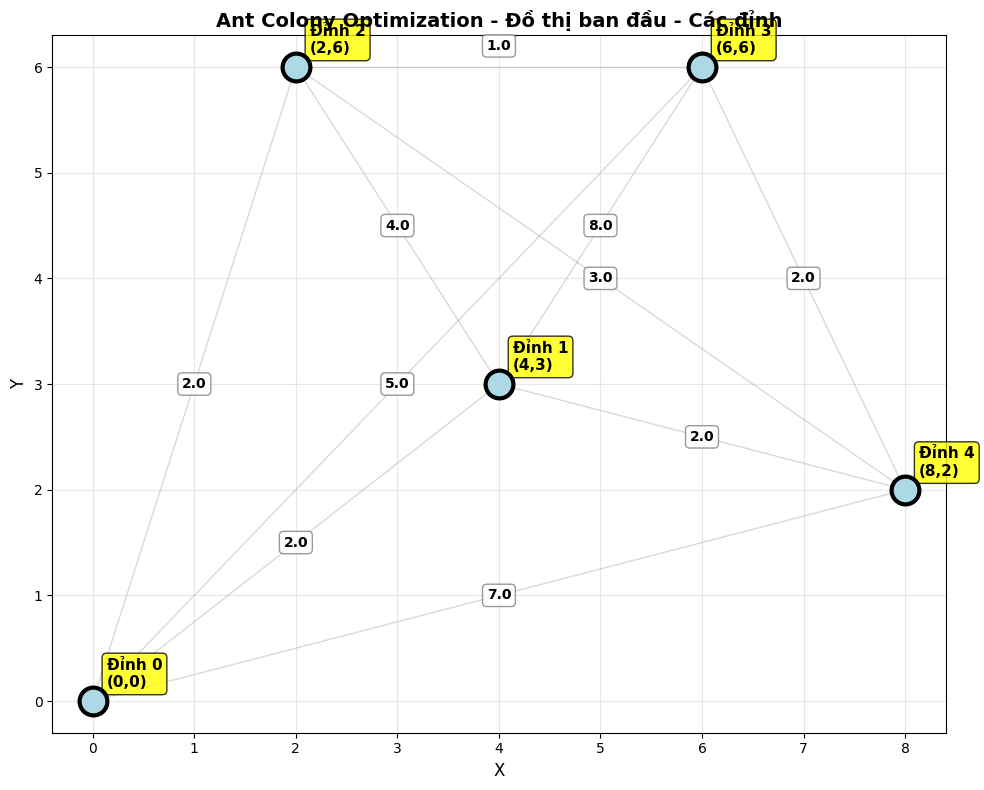

=== Iteration 1 ===


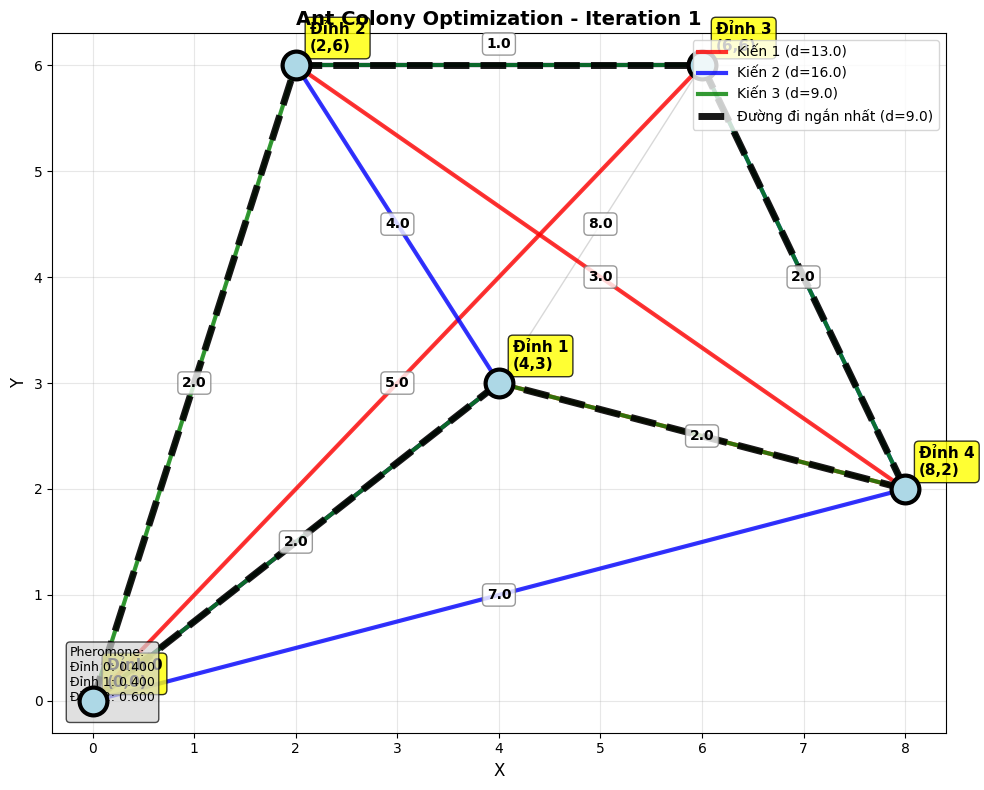

Đường đi của các con kiến trong iteration 1:
  Kiến 1:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→4(8, 2) → 4(8, 2)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→0(0, 0)
    Tổng khoảng cách: 13.00
  Kiến 2:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→0(0, 0)
    Tổng khoảng cách: 16.00
  Kiến 3:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Đường đi ngắn nhất iteration này: 9.00

=== Iteration 2 ===


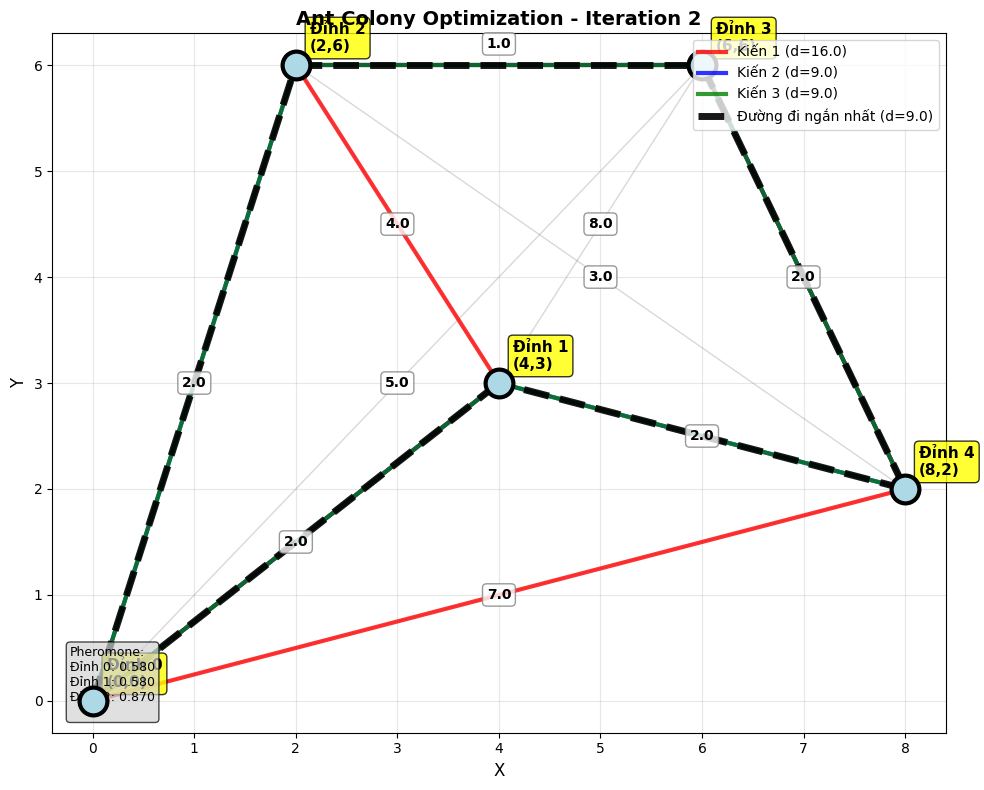

Đường đi của các con kiến trong iteration 2:
  Kiến 1:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→0(0, 0)
    Tổng khoảng cách: 16.00
  Kiến 2:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 3:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→4(8, 2) → 4(8, 2)→3(6, 6) → 3(6, 6)→2(2, 6) → 2(2, 6)→0(0, 0)
    Tổng khoảng cách: 9.00
  Đường đi ngắn nhất iteration này: 9.00

=== Iteration 3 ===


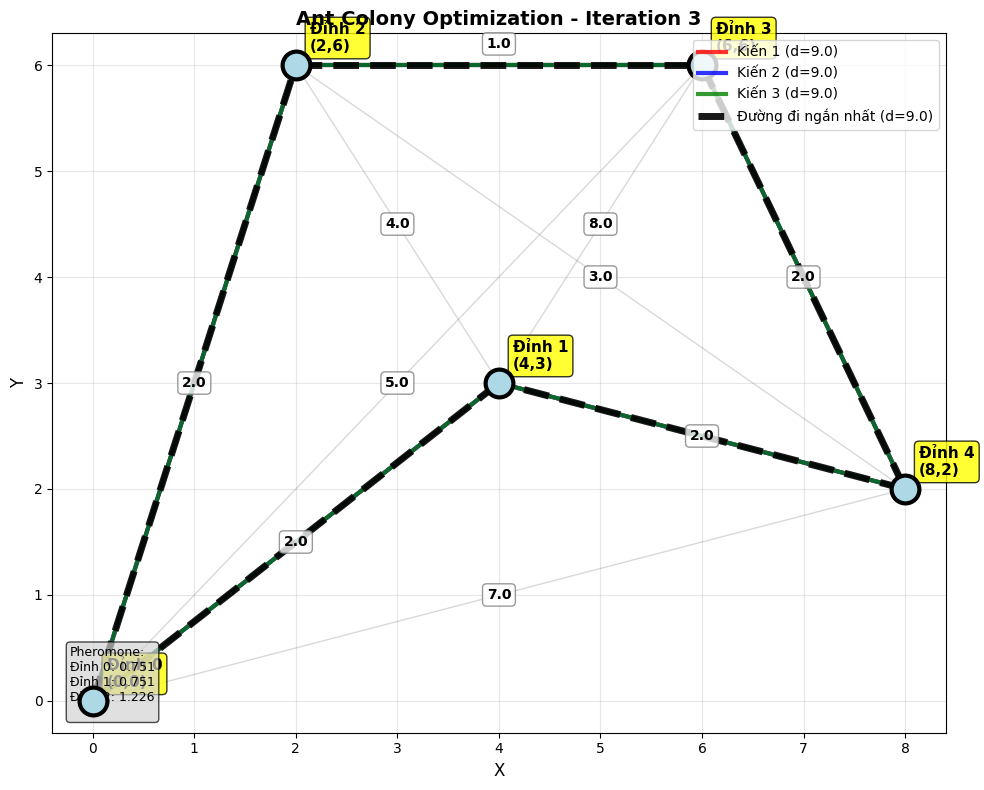

Đường đi của các con kiến trong iteration 3:
  Kiến 1:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 2:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 3:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Đường đi ngắn nhất iteration này: 9.00

=== Iteration 4 ===


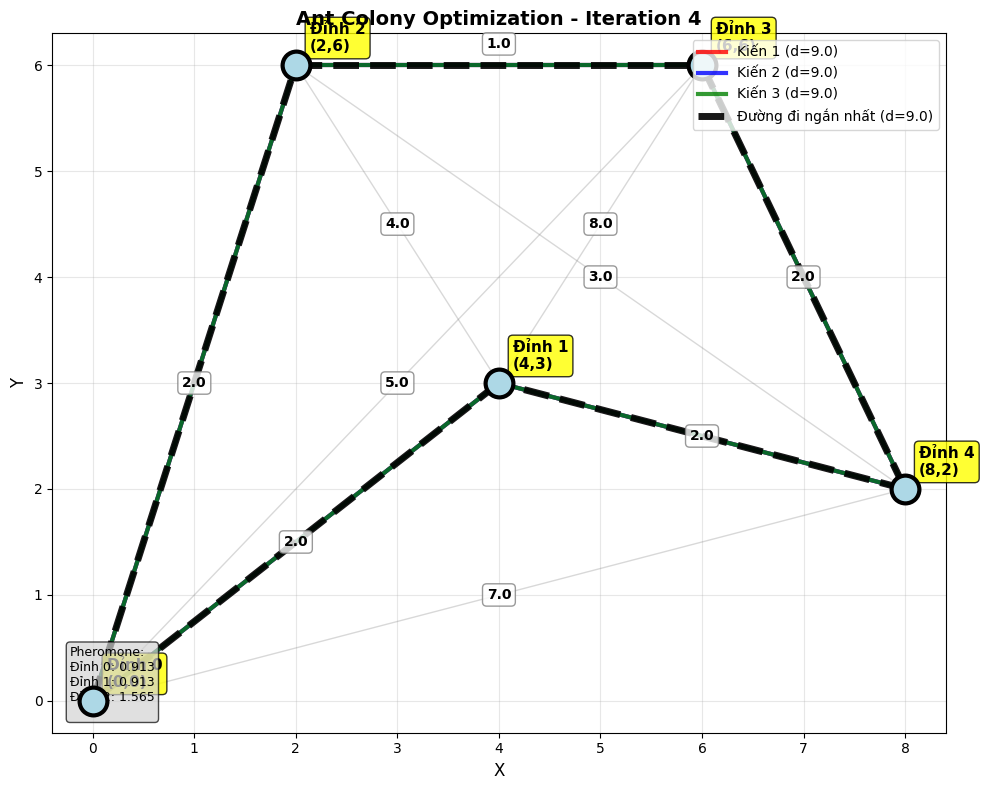

Đường đi của các con kiến trong iteration 4:
  Kiến 1:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 2:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 3:
    Đường đi: 0(0, 0)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→4(8, 2) → 4(8, 2)→1(4, 3) → 1(4, 3)→0(0, 0)
    Tổng khoảng cách: 9.00
  Đường đi ngắn nhất iteration này: 9.00

=== Iteration 5 ===


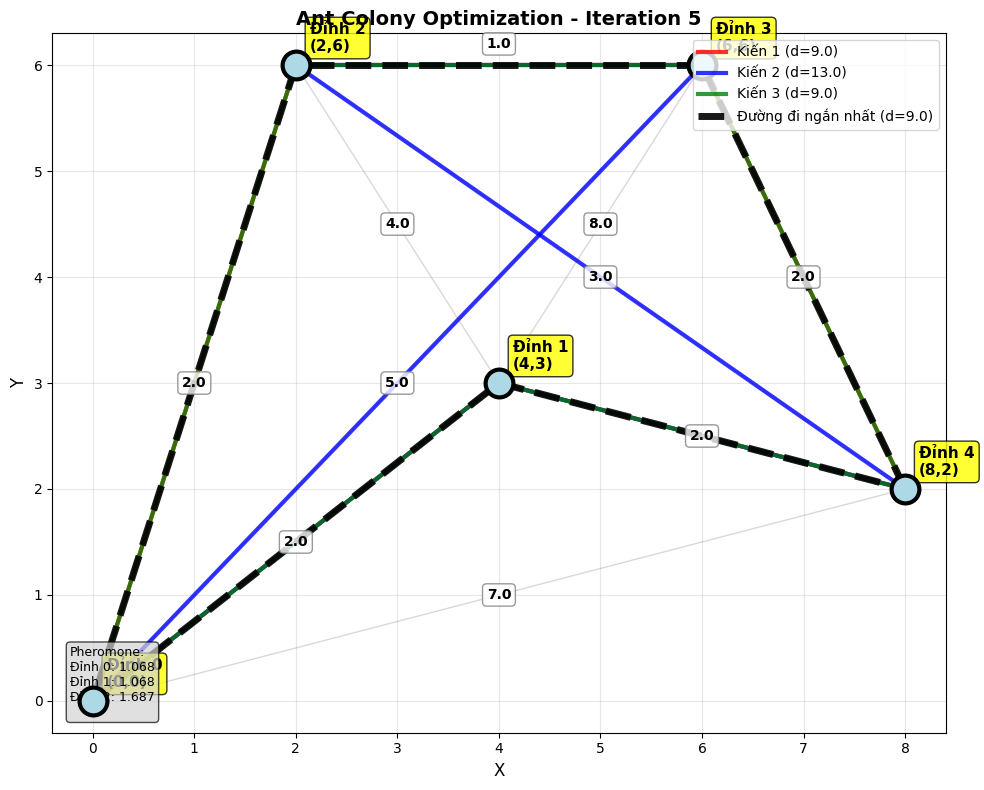

Đường đi của các con kiến trong iteration 5:
  Kiến 1:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→4(8, 2) → 4(8, 2)→3(6, 6) → 3(6, 6)→2(2, 6) → 2(2, 6)→0(0, 0)
    Tổng khoảng cách: 9.00
  Kiến 2:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→4(8, 2) → 4(8, 2)→2(2, 6) → 2(2, 6)→3(6, 6) → 3(6, 6)→0(0, 0)
    Tổng khoảng cách: 13.00
  Kiến 3:
    Đường đi: 0(0, 0)→1(4, 3) → 1(4, 3)→4(8, 2) → 4(8, 2)→3(6, 6) → 3(6, 6)→2(2, 6) → 2(2, 6)→0(0, 0)
    Tổng khoảng cách: 9.00
  Đường đi ngắn nhất iteration này: 9.00



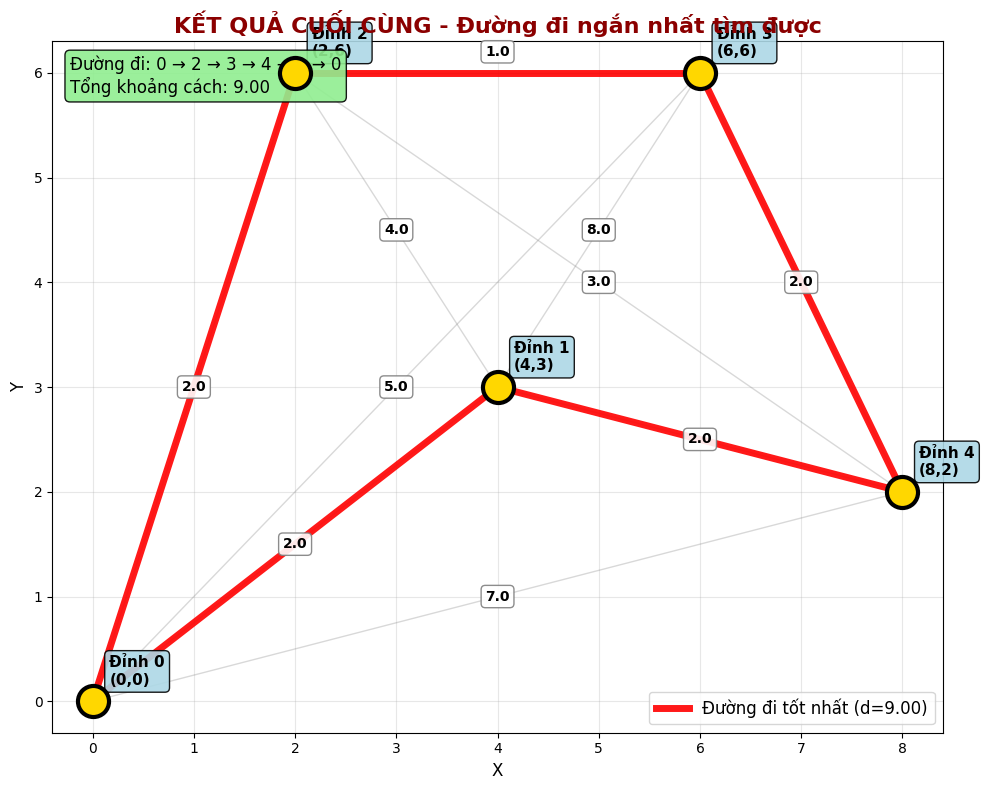


KẾT QUẢ CUỐI CÙNG:
Đường đi ngắn nhất: [(0, np.int64(2)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(4)), (np.int64(4), np.int64(1)), (np.int64(1), 0)]
Khoảng cách: 9.00

Chi tiết đường đi ngắn nhất:
  0(0, 0) → 2(2, 6) (khoảng cách: 2.0)
  2(2, 6) → 3(6, 6) (khoảng cách: 1.0)
  3(6, 6) → 4(8, 2) (khoảng cách: 2.0)
  4(8, 2) → 1(4, 3) (khoảng cách: 2.0)
  1(4, 3) → 0(0, 0) (khoảng cách: 2.0)


In [6]:

# Test với dữ liệu mẫu
import numpy as np

# Định nghĩa ma trận khoảng cách
distances = np.array([[np.inf, 2, 2, 5, 7],
                      [2, np.inf, 4, 8, 2],
                      [2, 4, np.inf, 1, 3],
                      [5, 8, 1, np.inf, 2],
                      [7, 2, 3, 2, np.inf]])

# Định nghĩa tọa độ các đỉnh (x, y) - tạo thành 1 hình để dễ quan sát
coordinates = [
    (0, 0),    # Đỉnh 0
    (4, 3),    # Đỉnh 1
    (2, 6),    # Đỉnh 2
    (6, 6),    # Đỉnh 3
    (8, 2)     # Đỉnh 4
]

print("Bắt đầu thuật toán Ant Colony Optimization...")
print("Mỗi iteration sẽ hiển thị đồ thị trong 2 giây")

# Khởi tạo và chạy thuật toán
ant_colony = AntColony(distances, coordinates, 3, 2, 5, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()

print("\n" + "="*60)
print("KẾT QUẢ CUỐI CÙNG:")
print(f"Đường đi ngắn nhất: {shortest_path[0]}")
print(f"Khoảng cách: {shortest_path[1]:.2f}")

# In chi tiết đường đi ngắn nhất
print("\nChi tiết đường đi ngắn nhất:")
for step in shortest_path[0]:
    from_node, to_node = step
    from_coord = coordinates[from_node]
    to_coord = coordinates[to_node]
    distance = distances[from_node, to_node]
    print(f"  {from_node}{from_coord} → {to_node}{to_coord} (khoảng cách: {distance})")